In [524]:
# Import libraries

import os
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

import yfinance as yf
import talib as ta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [523]:
# Loading Knowledge graph of linked entities
msft_tuples = pd.read_csv('msft_kg.csv')
msft_kg = msft_tuples[['Date','Head_Text','Head_MID',
                       'Relation','Relation_MID',
                       'Tail_Text','Tail_MID']].copy()
msft_kg.set_index(['Date'], inplace=True)

In [88]:
msft_kg.head(5)

,Head_Text,Head_MID,Relation,Relation_MID,Tail_Text,Tail_MID
Date,,,,,,
2015-01-02,Code update,Q188889,crash,P107,Bing,Q182496
2015-01-06,Sony,Q41187,praise,P119,employees,Q703534
2015-01-07,OSI Group LLC,Q2008123,aim,P155,FDA,Q204711
2015-01-13,US Senate,Q66096,seek,P164,visas,Q974595
2015-01-15,Wet Seal Inc.,Q7989983,file,P140,bankruptcy,Q152074


In [42]:
# Downloading MSFT historical data

# set date parameters     
startDate = dt.datetime(2015,1,1)
endDate = dt.datetime(2018,12,31)

msft_data = yf.download("MSFT", start=startDate, end=endDate)

# Save data
msft_data.to_csv('msft_hdata.csv')

[*********************100%***********************]  1 of 1 completed


In [89]:
# Load MSFT stock data
msft_hdata = pd.read_csv('msft_hdata.csv')
msft_hdata.set_index(['Date'], inplace=True)
msft_hdata.head(5)

,Open,High,Low,Close,AdjClose,Volume
Date,,,,,,
2015-01-02,46.660000,47.419998,46.540001,46.759998,41.647892,27913900
2015-01-05,46.369999,46.730000,46.250000,46.330002,41.264908,39673900
2015-01-06,46.380001,46.750000,45.540001,45.650002,40.659245,36447900
2015-01-07,45.980000,46.459999,45.490002,46.230000,41.175831,29114100
2015-01-08,46.750000,47.750000,46.720001,47.590000,42.387146,29645200


In [111]:
# Merge data

msft_merge = pd.merge(msft_kg, msft_hdata, how='inner', on=['Date'])

In [112]:
msft_merge.head(5)

,Head_Text,Head_MID,Relation,Relation_MID,Tail_Text,Tail_MID,Open,High,Low,Close,AdjClose,Volume
Date,,,,,,,,,,,,
2015-01-02,Code update,Q188889,crash,P107,Bing,Q182496,46.660000,47.419998,46.540001,46.759998,41.647892,27913900
2015-01-06,Sony,Q41187,praise,P119,employees,Q703534,46.380001,46.750000,45.540001,45.650002,40.659245,36447900
2015-01-07,OSI Group LLC,Q2008123,aim,P155,FDA,Q204711,45.980000,46.459999,45.490002,46.230000,41.175831,29114100
2015-01-13,US Senate,Q66096,seek,P164,visas,Q974595,46.970001,47.910000,46.060001,46.360001,41.291615,35270600
2015-01-15,Wet Seal Inc.,Q7989983,file,P140,bankruptcy,Q152074,46.220001,46.380001,45.410000,45.480000,40.507835,32750800


In [159]:
# Make copy of data
msft_alldata = msft_merge.copy() #.iloc[::-1,:]

In [160]:
# Calculations of Technical Indicators

# Price returns
msft_alldata['Returns'] = msft_alldata['AdjClose'].pct_change() 

# Stochastic oscillator (%K & %D)
msft_alldata['StochK'], msft_alldata['StochD'] = ta.STOCH(msft_alldata['High'], msft_alldata['Low'],
                                                          msft_alldata['AdjClose'],fastk_period=5,
                                                          slowk_period=3, slowk_matype=0, slowd_period=3,
                                                          slowd_matype=0)

# Larry William (LW) %R
msft_alldata['WillR'] = ta.WILLR(msft_alldata['High'], msft_alldata['Low'], 
                                 msft_alldata['AdjClose'],timeperiod=14)


# Relative Strength Index (RSI)
msft_alldata['RSI'] = ta.RSI(msft_alldata['AdjClose'], timeperiod=14)


# Target variable: 
# If close price (t+1) > close price (t) then set 1 (buy stock), otherwise 0 (sell stock) 
msft_alldata['Target'] = np.where(msft_alldata['AdjClose'].shift(-1) > msft_alldata['AdjClose'], 1, 0)


In [174]:
# Fetch data needed for next stage.
msft_consol = msft_alldata[['Head_MID','Relation_MID','Tail_MID',
                           'Returns', 'StochK', 'StochD', 'WillR', 'RSI', 'Target']].copy()

# Replace all NaN values with column median
msft_consol['Returns'].fillna(msft_consol['Returns'].median(), inplace=True)
msft_consol['StochK'].fillna(msft_consol['StochK'].median(), inplace=True)
msft_consol['StochD'].fillna(msft_consol['StochD'].median(), inplace=True)
msft_consol['WillR'].fillna(msft_consol['WillR'].median(), inplace=True)
msft_consol['RSI'].fillna(msft_consol['RSI'].median(), inplace=True)
#msft_alldata.fillna(0, inplace=True)

In [175]:
msft_consol.head()

,Head_MID,Relation_MID,Tail_MID,Returns,StochK,StochD,WillR,RSI,Target
Date,,,,,,,,,
2015-01-02,Q188889,P107,Q182496,0.000843,-115.690568,-115.799049,-123.144586,57.343551,0
2015-01-06,Q41187,P119,Q703534,-0.023738,-115.690568,-115.799049,-123.144586,57.343551,1
2015-01-07,Q2008123,P155,Q204711,0.012705,-115.690568,-115.799049,-123.144586,57.343551,1
2015-01-13,Q66096,P164,Q974595,0.002812,-115.690568,-115.799049,-123.144586,57.343551,0
2015-01-15,Q7989983,P140,Q152074,-0.018982,-115.690568,-115.799049,-123.144586,57.343551,1


In [500]:
# Fetch data for KG embeddings processing
msft_kgc = msft_consol[['Head_MID','Tail_MID','Relation_MID']].copy()

msft_tec = msft_consol[['Head_MID','Relation_MID','Tail_MID']].copy()

In [501]:
msft_tec.head()

,Head_MID,Relation_MID,Tail_MID
Date,,,
2015-01-02,Q188889,P107,Q182496
2015-01-06,Q41187,P119,Q703534
2015-01-07,Q2008123,P155,Q204711
2015-01-13,Q66096,P164,Q974595
2015-01-15,Q7989983,P140,Q152074


In [502]:
# Additional columns
msft_tec['Tuple'] = msft_tec.apply(lambda x: ', '.join(x), axis=1)
msft_tec['Entities'] = msft_tec[['Head_MID','Tail_MID']].apply(lambda x: ', '.join(x), axis=1)

In [503]:
msft_tec

,Head_MID,Relation_MID,Tail_MID,Tuple,Entities
Date,,,,,
2015-01-02,Q188889,P107,Q182496,"Q188889, P107, Q182496","Q188889, Q182496"
2015-01-06,Q41187,P119,Q703534,"Q41187, P119, Q703534","Q41187, Q703534"
2015-01-07,Q2008123,P155,Q204711,"Q2008123, P155, Q204711","Q2008123, Q204711"
2015-01-13,Q66096,P164,Q974595,"Q66096, P164, Q974595","Q66096, Q974595"
2015-01-15,Q7989983,P140,Q152074,"Q7989983, P140, Q152074","Q7989983, Q152074"
...,...,...,...,...,...
2018-12-03,Q11201,P162,Q2283,"Q11201, P162, Q2283","Q11201, Q2283"
2018-12-06,Q2283,P133,Q43627,"Q2283, P133, Q43627","Q2283, Q43627"
2018-12-07,Q2283,P100,Q92296582,"Q2283, P100, Q92296582","Q2283, Q92296582"


In [491]:
# Split KG into training and test sets
kg_train,kg_test = train_test_split(msft_kgc,test_size=0.2, random_state=42)

# te_train,te_test = train_test_split(msft_tec['Tuple'],test_size=0.2, random_state=42)

In [492]:
# kg_valid,kg_test = train_test_split(kg_remain, test_size=0.40, random_state=42)

In [493]:
# Drop duplicate rows
#kg_train_uniq = kg_train.drop_duplicates()
#kg_valid_uniq = kg_valid.drop_duplicates()
#kg_test_uniq = kg_test.drop_duplicates()

In [504]:
# Save KGs
msft_kgc.to_csv('./data/KGE/kgc.txt', sep="\t", header=None, index=False )
kg_train.to_csv('./data/KGE/train.txt', sep="\t", header=None, index=False )
kg_test.to_csv('./data/KGE/test.txt', sep="\t", header=None, index=False )

msft_tec['Tuple'].to_csv('./data/KGE/tec.txt', sep="\t", header=None, index=False )
msft_tec['Entities'].to_csv('./data/KGE/tec_entity.txt', sep="\t", header=None, index=False )

In [537]:
# Get stock data without KG embeddings
msft_woemb = msft_consol[['Returns','StochK','StochD',
                          'WillR','RSI', 'Target']].copy()

In [538]:
X_woemb = msft_woemb[['Returns','StochK',
                          'WillR','RSI']].copy()

In [539]:
X_woemb.head()

,Returns,StochK,WillR,RSI
Date,,,,
2015-01-02,0.000843,-115.690568,-123.144586,57.343551
2015-01-06,-0.023738,-115.690568,-123.144586,57.343551
2015-01-07,0.012705,-115.690568,-123.144586,57.343551
2015-01-13,0.002812,-115.690568,-123.144586,57.343551
2015-01-15,-0.018982,-115.690568,-123.144586,57.343551


In [582]:
# Get target from data
y = np.ravel(msft_woemb['Target'])

In [541]:
# Standardization for features (X_woemb)

scaler = StandardScaler()
#X = scaler.fit_transform(X_woemb)
X_woe = pd.DataFrame(scaler.fit_transform(X_woemb.to_numpy()), columns=X_woemb.columns, index=X_woemb.index)
X_woe.head()

,Returns,StochK,WillR,RSI
Date,,,,
2015-01-02,-0.035411,-0.016499,0.176882,0.001747
2015-01-06,-1.456557,-0.016499,0.176882,0.001747
2015-01-07,0.650385,-0.016499,0.176882,0.001747
2015-01-13,0.078413,-0.016499,0.176882,0.001747
2015-01-15,-1.181554,-0.016499,0.176882,0.001747


In [571]:
# Load KG embeddings
kgml_emb = pd.read_csv('kgml_embedding.csv')

In [572]:
kgml_emb.head()

,PC1,PC2
0,-0.107480,-0.064257
1,-0.187027,-0.032763
2,-0.161993,0.659205
3,-0.092571,-0.108001
4,-0.138446,0.066147


In [593]:
# Merge embedding and X_woemb
ex_merged = pd.concat([kgml_emb, X_woe.reset_index()], axis=1)
add_y = pd.concat([ex_merged,pd.DataFrame(y, columns=['Target'])], axis=1)
kg_complete = add_y.copy()

In [594]:
kg_complete.set_index(['Date'], inplace=True)

In [595]:
kg_complete.head()

,PC1,PC2,Returns,StochK,WillR,RSI,Target
Date,,,,,,,
2015-01-02,-0.107480,-0.064257,-0.035411,-0.016499,0.176882,0.001747,0
2015-01-06,-0.187027,-0.032763,-1.456557,-0.016499,0.176882,0.001747,1
2015-01-07,-0.161993,0.659205,0.650385,-0.016499,0.176882,0.001747,1
2015-01-13,-0.092571,-0.108001,0.078413,-0.016499,0.176882,0.001747,0
2015-01-15,-0.138446,0.066147,-1.181554,-0.016499,0.176882,0.001747,1


In [601]:
#Save embedding
kg_complete.to_csv('kg_complete.csv', index=False)

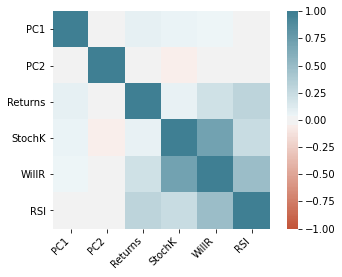

In [569]:
# Check correlation with heatmap graph

corr = x_complete.corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [607]:
# Load TransE embedding
te_embd = pd.read_csv('te_embedding.csv')

In [608]:
te_embd.drop(te_embd.columns[te_embd.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [609]:
te_embd.head()

,ent1PC1,ent1PC2,ent2PC1,ent2PC2
0,0.223980,0.260527,0.018174,0.220696
1,0.396025,0.123712,-0.033438,0.314318
2,-0.033738,0.145388,-0.001960,0.225625
3,-0.061627,0.180608,0.041613,-0.137706
4,0.147277,-0.237953,-0.321499,0.335000


In [612]:
# Merge TransE embedding and X_woemb
te_merged = pd.concat([te_embd, X_woe.reset_index()], axis=1)
te_y = pd.concat([te_merged,pd.DataFrame(y, columns=['Target'])], axis=1)
te_complete = te_y.copy()

In [613]:
te_complete.set_index(['Date'], inplace=True)

In [615]:
te_complete.head()

,ent1PC1,ent1PC2,ent2PC1,ent2PC2,Returns,StochK,WillR,RSI,Target
Date,,,,,,,,,
2015-01-02,0.223980,0.260527,0.018174,0.220696,-0.035411,-0.016499,0.176882,0.001747,0
2015-01-06,0.396025,0.123712,-0.033438,0.314318,-1.456557,-0.016499,0.176882,0.001747,1
2015-01-07,-0.033738,0.145388,-0.001960,0.225625,0.650385,-0.016499,0.176882,0.001747,1
2015-01-13,-0.061627,0.180608,0.041613,-0.137706,0.078413,-0.016499,0.176882,0.001747,0
2015-01-15,0.147277,-0.237953,-0.321499,0.335000,-1.181554,-0.016499,0.176882,0.001747,1


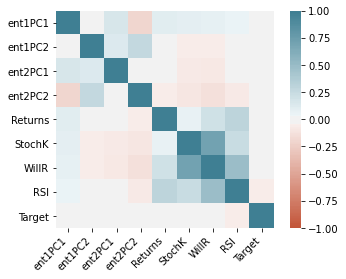

In [616]:
# Check correlation with heatmap graph

corr = te_complete.corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [617]:
#Save Transe embedding
te_complete.to_csv('te_complete.csv', index=False)

In [621]:
# Merge baseline data 
bl_merged = pd.concat([X_woe.reset_index(),pd.DataFrame(y, columns=['Target'])], axis=1)
bl_merged.set_index(['Date'], inplace=True)

In [626]:
bl_merged.head()

,Returns,StochK,WillR,RSI,Target
Date,,,,,
2015-01-02,-0.035411,-0.016499,0.176882,0.001747,0
2015-01-06,-1.456557,-0.016499,0.176882,0.001747,1
2015-01-07,0.650385,-0.016499,0.176882,0.001747,1
2015-01-13,0.078413,-0.016499,0.176882,0.001747,0
2015-01-15,-1.181554,-0.016499,0.176882,0.001747,1


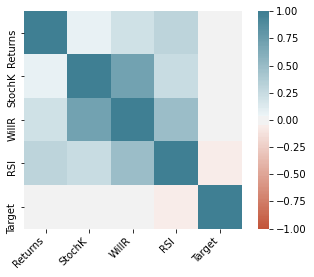

In [627]:
# Check correlation with heatmap graph

corr = bl_merged.corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [628]:
bl_merged.to_csv('bl_merged.csv', index=False)

In [629]:
len(bl_merged)

657